In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split

# from sklearn.surprise import Dataset, Reader
# from surprise.model_selection import train_test_split
# from surprise import SVD

In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Cleaning

In [4]:
# Checking and removing NaNs

movies_nan = movies.isna().sum()
ratings_nan = ratings.isna().sum()
tags_nan = tags.isna().sum()
links_nan = links.isna().sum()
print("NaN counts in movies:\n", movies_nan)
print("\nNaN counts in ratings:\n", ratings_nan)
print("\nNaN counts in tags:\n", tags_nan)
print("\nNaN counts in links:\n", links_nan)

# TMDB ID the only column with NaNs
links['tmdbId'].fillna('Unknown', inplace=True)
movies



NaN counts in movies:
 movieId    0
title      0
genres     0
dtype: int64

NaN counts in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

NaN counts in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

NaN counts in links:
 movieId    0
imdbId     0
tmdbId     8
dtype: int64


C:\Users\betht\AppData\Local\Temp\ipykernel_20120\532870775.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  links['tmdbId'].fillna('Unknown', inplace=True)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
# Removing duplicates
ratings.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
tags.drop_duplicates(subset=['userId', 'movieId', 'tag'], inplace=True)

# Data type conversion
movies['movieId'] = movies['movieId'].astype(int)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# Standardizing text
movies['title'] = movies['title'].str.lower()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x).lower())

movies['genres'] = movies['genres'].str.split('|')
# Extract year from the title and create a new 'year' column
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Remove the year from the 'title' column
movies['title'] = movies['title'].str.rsplit(' (', n=1).str[0]
# Assuming the 'timestamp' column is in your 'ratings' DataFrame
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
print(movies)



      movieId                               title  \
0           1                           toy story   
1           2                             jumanji   
2           3                    grumpier old men   
3           4                   waiting to exhale   
4           5         father of the bride part ii   
...       ...                                 ...   
9737   193581  black butler: book of the atlantic   
9738   193583               no game no life: zero   
9739   193585                               flint   
9740   193587        bungo stray dogs: dead apple   
9741   193609        andrew dice clay: dice rules   

                                                 genres  year  
0     [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                        [Adventure, Children, Fantasy]  1995  
2                                     [Comedy, Romance]  1995  
3                              [Comedy, Drama, Romance]  1995  
4                                          

## Data Merging

In [6]:
movie_ratings = pd.merge(movies, ratings, on='movieId')
movie_ratings_tags = pd.merge(movie_ratings, tags, on=['movieId', 'userId'], how='left')
final_dataset = pd.merge(movie_ratings_tags, links, on='movieId', how='left')
final_dataset.head()

,movieId,title,genres,year,userId,rating,timestamp_x,tag,timestamp_y,imdbId,tmdbId
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1,4.0,2000-07-30 18:45:03,NaN,NaT,114709,862.0
1,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5,4.0,1996-11-08 06:36:02,NaN,NaT,114709,862.0
2,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,7,4.5,2005-01-25 06:52:26,NaN,NaT,114709,862.0
3,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,15,2.5,2017-11-13 12:59:30,NaN,NaT,114709,862.0
4,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,17,4.5,2011-05-18 05:28:03,NaN,NaT,114709,862.0


In [7]:
final_dataset_nan = final_dataset.isna().sum()
print("NaN counts in movies:\n", final_dataset_nan)
# Counting non-NaN values in the 'tag' column
non_nan_count_tag = final_dataset['tag'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'tag':", non_nan_count_tag)
# Counting non-NaN values in the 'tag' column
non_nan_count_timestamp_y = final_dataset['timestamp_y'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'timestamp_y':", non_nan_count_timestamp_y)

# Fill NaN values in 'tag' with 'No Tag'
final_dataset['tag'].fillna('No Tag', inplace=True)

# Drop 'timestamp_y' if not needed
final_dataset.drop(columns=['timestamp_y'], inplace=True)

final_dataset = final_dataset.rename(columns={'timestamp_x': 'timestamp'})


final_dataset.head()

NaN counts in movies:
 movieId            0
title              0
genres             0
year              20
userId             0
rating             0
timestamp_x        0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId             0
dtype: int64
Number of non-NaN values in 'tag': 3476
Number of non-NaN values in 'timestamp_y': 3476


,movieId,title,genres,year,userId,rating,timestamp,tag,imdbId,tmdbId
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0
1,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0
2,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0
3,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0
4,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0


## Feature Engineering- Timestamps to reflect trends

In [8]:


# Adjust the decay factor
decay_factor = 0.99

# Ensure correct conversion of timestamp to datetime
final_dataset['timestamp'] = pd.to_datetime(final_dataset['timestamp'])

# Calculate the age of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Apply the decay function
final_dataset['rating_weight'] = decay_factor ** final_dataset['rating_age_days']

# Calculate the weighted rating score (without dividing by frequency)
weighted_rating_score = final_dataset.groupby('movieId').apply(lambda x: np.mean(x['rating_weight'])).reset_index(name='weighted_rating_score')

# Normalize the scores (optional, can use min-max scaling or z-score standardization)

scaler = MinMaxScaler()
weighted_rating_score['normalized_score'] = scaler.fit_transform(weighted_rating_score[['weighted_rating_score']])

# Merge with the main dataset if needed
final_dataset = final_dataset.merge(weighted_rating_score, on='movieId')

# Now, you can use 'normalized_score' as your trending score
normalized_scores = weighted_rating_score['normalized_score']


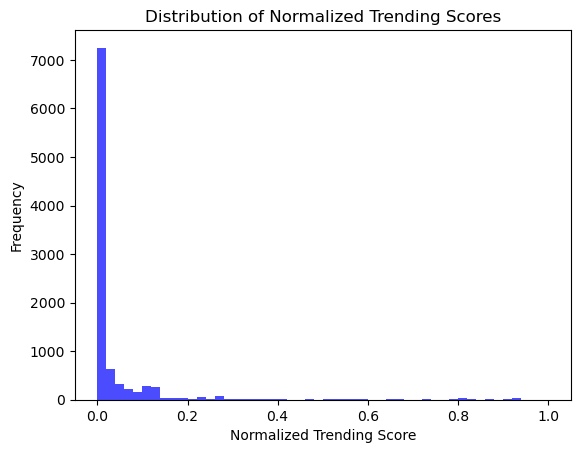

count    102677.000000
mean          0.023182
std           0.051619
min           0.000000
25%           0.000958
50%           0.010688
75%           0.026115
max           1.000000
Name: normalized_score, dtype: float64


In [9]:

# Plotting a histogram
plt.hist(normalized_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Trending Scores')
plt.xlabel('Normalized Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_normalized_score = final_dataset['normalized_score'].describe()
print(highest_normalized_score)


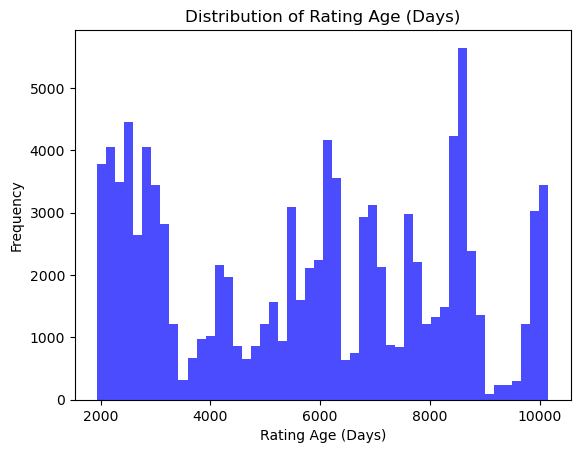

In [10]:
# Check distribution of rating_age_days
plt.hist(final_dataset['rating_age_days'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Rating Age (Days)')
plt.xlabel('Rating Age (Days)')
plt.ylabel('Frequency')
plt.show()




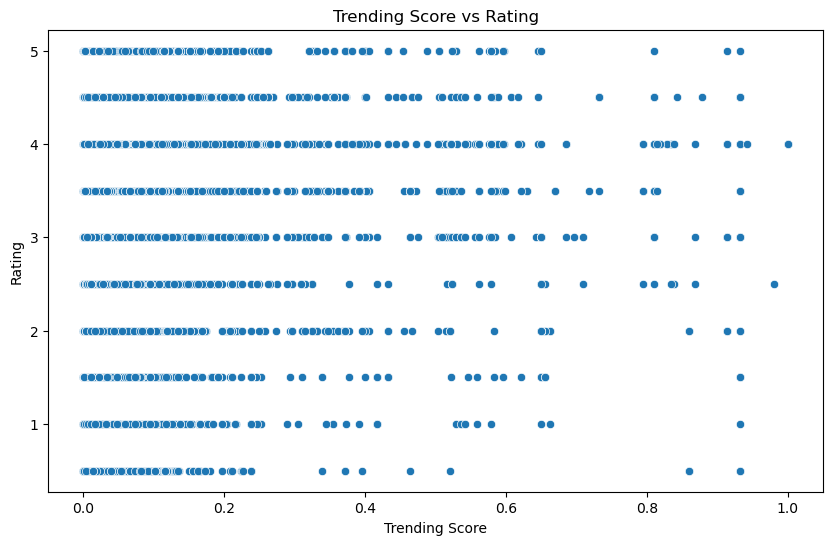

Correlation between Trending Score and Rating: 0.03030814995432012


In [11]:
# Scatter plot of 'trending score' vs 'ratings'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_score', y='rating', data=final_dataset)
plt.title('Trending Score vs Rating')
plt.xlabel('Trending Score')
plt.ylabel('Rating')
plt.show()

# Calculating the correlation
correlation = final_dataset['normalized_score'].corr(final_dataset['rating'])
print("Correlation between Trending Score and Rating:", correlation)


In [12]:
final_dataset.head()

,movieId,title,genres,year,userId,rating,timestamp,tag,imdbId,tmdbId,rating_age_days,rating_weight,weighted_rating_score,normalized_score
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0,8569,3.962621e-38,5.311752e-11,0.015752
1,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0,9930,4.544461e-44,5.311752e-11,0.015752
2,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0,6930,5.648050e-31,5.311752e-11,0.015752
3,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0,2255,1.436692e-10,5.311752e-11,0.015752
4,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0,4626,6.432950e-21,5.311752e-11,0.015752


In [13]:
weighted_rating_score.head()

,movieId,weighted_rating_score,normalized_score
0,1,5.311752e-11,1.575161e-02
1,2,5.550021e-11,1.645818e-02
2,3,6.705558e-13,1.988485e-04
3,4,3.408593e-25,1.010793e-16
4,5,6.720880e-12,1.993028e-03


In [14]:
movies

,movieId,title,genres,year
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,jumanji,"[Adventure, Children, Fantasy]",1995
2,3,grumpier old men,"[Comedy, Romance]",1995
3,4,waiting to exhale,"[Comedy, Drama, Romance]",1995
4,5,father of the bride part ii,[Comedy],1995
...,...,...,...,...
9737,193581,black butler: book of the atlantic,"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,no game no life: zero,"[Animation, Comedy, Fantasy]",2017
9739,193585,flint,[Drama],2017
9740,193587,bungo stray dogs: dead apple,"[Action, Animation]",2018


In [15]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,boxing story,2015-10-24 19:33:27
4,2,89774,mma,2015-10-24 19:33:20
...,...,...,...,...
3678,606,7382,for katie,2007-02-11 22:46:59
3679,606,7936,austere,2007-03-08 22:18:54
3680,610,3265,gun fu,2017-05-03 20:39:44
3681,610,3265,heroic bloodshed,2017-05-03 20:39:38


## Content- based filtering

In [16]:

movies['genres'] = movies['genres'].astype(str)
tags['tag'] = tags['tag'].astype(str)
# Combine genres and tags 
movies = movies.merge(tags, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')
movies['metadata'] = movies['genres'] + ' ' + movies['tag']

# Create a TF-IDF Vectorizer and transform the metadata to a matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['metadata'])

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on content similarity
def get_content_based_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = movies.index[movies['title'] == title].tolist()[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

# Example usage
recommendations = get_content_based_recommendations('toy story')
print(recommendations)


1                                     toy story
3214                                toy story 2
3217                                toy story 2
2484                              bug's life, a
8672                                         up
2422                                       antz
3753    adventures of rocky and bullwinkle, the
3966                  emperor's new groove, the
4633                             monsters, inc.
7617                                  wild, the
Name: title, dtype: object


## Collaborative merged with trending scores

In [17]:


# Load the ratings dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.25)

#Chosen algorithm
svd = SVD()
svd.fit(trainset)

# Predict ratings for the testset
predictions = svd.test(testset)

# Integrate trending scores in the recommendation phase
def get_collaborative_recommendations(user_id, trending_scores, top_n=10):
    # Predict ratings for all movies for the given user
    movie_ids = ratings['movieId'].unique()
    predicted_ratings = [svd.predict(user_id, movie_id).est for movie_id in movie_ids]

    # Combine predictions with trending scores
    movie_rating_trend = pd.DataFrame({'movieId': movie_ids, 'predicted_rating': predicted_ratings})
    movie_rating_trend = movie_rating_trend.merge(trending_scores, on='movieId')

    # Calculating a hybrid score
    movie_rating_trend['hybrid_score'] = movie_rating_trend['predicted_rating'] * movie_rating_trend['normalized_score']

    # Get top N recommendations
    top_recommendations = movie_rating_trend.sort_values(by='hybrid_score', ascending=False).head(top_n)
    return top_recommendations

# Example usage
user_id = 1  
trending_scores = weighted_rating_score[['movieId', 'normalized_score']]  
top_recommendations = get_collaborative_recommendations(user_id, trending_scores, top_n=10)


top_recommendations = top_recommendations.merge(movies[['movieId', 'title']], on='movieId')
print(top_recommendations[['title', 'hybrid_score']])


                                                title  hybrid_score
0                                       emerald green      4.377404
1                                            ruby red      4.249276
2                                       sapphire blue      4.183208
3                                  gintama: the movie      4.105558
4                                  gintama: the movie      4.105558
5                                  gintama: the movie      4.105558
6                                  gintama: the movie      4.105558
7                          shake hands with the devil      4.099962
8                          unedited footage of a bear      4.093870
9     anohana: the flower we saw that day - the movie      4.058981
10  too funny to fail: the life and death of the d...      4.051631
11                     the stanford prison experiment      4.045430
12                   the night is short, walk on girl      4.037002


## combining the 3

In [18]:
def get_unified_recommendations(user_id, trending_scores, tfidf_matrix, cosine_sim, movies, top_n=10):
    # Get collaborative recommendations
    collaborative_recs = get_collaborative_recommendations(user_id, trending_scores, 5)

    # Get similar movies for each collaborative recommendation using content-based method
    content_based_recs = pd.DataFrame()
    for movie_id in collaborative_recs['movieId']:
        title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
        similar_movies = get_content_based_recommendations(title, cosine_sim, movies)
        
        # Get the top 1 similar movie for each collaborative recommendation
        if not similar_movies.empty:
            top_similar = similar_movies.head(1)
            content_based_recs = pd.concat([content_based_recs, top_similar])

    # Combine collaborative and content-based recommendations
    unified_recommendations = pd.concat([collaborative_recs, content_based_recs]).drop_duplicates().head(top_n)

    return unified_recommendations



In [19]:
# # Assume 'final_dataset' is your main dataset and includes user, movie, rating, and timestamp
# # Assume 'ratings' is a DataFrame that includes userId, movieId, and rating, which will be used for collaborative filtering
# # 'movies' should include movieId, title, and genres
# # 'tags' should include movieId and tag
# # The trending score calculation code has been run, so 'weighted_rating_score' includes a normalized_score for each movie

# # Combine the trending score with the movie data
# movies = movies.merge(weighted_rating_score[['movieId', 'normalized_score']], on='movieId')

# # After fitting a model (e.g., SVD or KNN), you would get predictions for each movie for a given user
# # Here's an example with the SVD algorithm
# from surprise import SVD, Dataset, Reader
# from surprise.model_selection import train_test_split

# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# trainset, testset = train_test_split(data, test_size=0.25)

# svd = SVD()
# svd.fit(trainset)

# # Now, when you make predictions, you can adjust them using the trending score
# user_id = 1  # Example user ID
# user_ratings = trainset.ur[trainset.to_inner_uid(user_id)]
# predictions = []
# for movie_id in trainset.all_items():
#     movie_raw_id = trainset.to_raw_iid(movie_id)
#     movie_data = movies[movies['movieId'] == movie_raw_id]
#     if not movie_data.empty:
#         # Get the SVD prediction
#         svd_prediction = svd.predict(user_id, movie_raw_id).est
#         # Adjust the prediction with the trending score
#         trending_score = movie_data['normalized_score'].iloc[0]
#         hybrid_score = svd_prediction * trending_score  # Example combination
#         predictions.append((movie_raw_id, hybrid_score))

# # Sort the predictions by the hybrid score
# predictions.sort(key=lambda x: x[1], reverse=True)

# # Get the top N recommendations
# top_n_recommendations = predictions[:5]  # Get the top 5
# top_n_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in top_n_recommendations]


## Merging all 3 ( assuming that collaborative and trend were done separately)

In [20]:
# from surprise import Reader, Dataset, KNNBasic
# from surprise.model_selection import train_test_split

# # Load your dataset with ratings
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.loadfrom_df(ratings[['userId', 'movieId', 'rating']], reader)

# #split the data into training and test sets
# trainset, testset = train_test_split(data, test_size=0.25)

# #Use KNN to find similar users
# sim_options = {
# 'name': 'cosine',
# 'user_based': True # compute similarities between users
# }
# knn = KNNBasic(sim_options=sim_options)
# knn.fit(trainset)